<a href="https://colab.research.google.com/github/jang-jin/mini_project1_news_title_generator/blob/master/modeling/Attention_in_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/AI-school/로테이션 수업 자료/NLP/project

/content/drive/My Drive/Colab Notebooks/AI-school/로테이션 수업 자료/NLP/project


# Library import

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Data preprocess

In [ ]:
thesciencetimes = pd.read_csv("./p_thesciencetimes.csv", header=None)
print(thesciencetimes.shape)
kbsnews = pd.read_csv("./p_kbsnews.csv", header=None)
print(kbsnews.shape)
news_dataset = pd.concat([thesciencetimes, kbsnews])
print(news_dataset.shape)
news_dataset.head()

(15328, 3)
(10861, 3)
(26189, 3)


,0,1,2
0,20200826,미국 최초로 GM 모기 살포 실험,"미국 남부, 플로리다 주에 길이 약 240km의 산호초 군도가 있다. 플로리다키스 ..."
1,20200826,공룡도 척추 디스크로 고생했다,척추 디스크는 현대인에게서 가장 많이 발생하는 질환 중 하나다. 국민건강보험공단 등...
2,20200826,투명 고분자 물질 레이저로 초고속 가공하는 기술 개발,한국연구재단은 서울대 고승환·전누리 교수 연구팀이 투명 물질인 ‘폴리디메틸실록산'(...
3,20200825,"기초지원연, 물속 중금속 흡착 철산화물 나노입자 섬유 개발",한국기초과학지원연구원은 박종배 박사 연구팀이 물속 중금속을 흡착할 수 있는 철산화물...
4,20200824,"산업부, 중기 개발한 소재부품장비 양산 위한 성능평가 지원",산업통상자원부는 ‘2020년도 소재·부품·장비(소부장) 양산 성능평가 지원사업’을 ...


In [ ]:
news_dataset = news_dataset.sample(frac=1, random_state=13)

In [ ]:
news_dataset[1] = news_dataset[1].str.replace("[^\w]", " ")
news_dataset[2] = news_dataset[2].str.replace("[^\w]", " ")
news_dataset[1] = news_dataset[1].replace("", np.nan)
news_dataset[2] = news_dataset[2].replace("", np.nan)
news_dataset = news_dataset.dropna(how='any')
print(news_dataset.shape)
news_dataset.head()

(26189, 3)


,0,1,2
5565,20160127,제조업 차이나한파 주의보 IT마저 흔들,대한상공회의소가 최근 10여개 업종단체와 공동으로 실시한 2016년 산업 기상도 ...
4464,20130115,파종에서 재배 수확까지 로봇이 농사꾼,로봇이 위기의 농업을 살릴 구세주로 떠오르고 있다 사람이 파종하는 것보다 10배 ...
13828,20170405,AI와 융합한 CCTV의 진화,지난해 10월 일본 프로축구 J리그 결승전이 열린 사이타나 스타디움에서는 좀처럼 보...
1567,20190207,고품질 흑연 제조법 개발 성공,기초과학연구원 IBS 은 로드니 루오프 다차원 탄소재료 연구단장 울산과학기술원 자연...
6572,20170313,VR National Parks,If it s difficult for you to take the time to ...


In [ ]:
encoder_input, decoder_input, decoder_output = [], [], []

for stc in news_dataset[2]:
    encoder_input.append(stc.split())

# 스타트 뒤에 띄어쓰기
for stc in news_dataset[1]:
    decoder_input.append(("<start> "+stc).split())

for stc in news_dataset[1]:
    decoder_output.append((stc+" <end>").split())

print(encoder_input[:3])
print(decoder_input[:3])
print(decoder_output[:3])

[['대한상공회의소가', '최근', '10여개', '업종단체와', '공동으로', '실시한', '2016년', '산업', '기상도', '조사', '결과를', '발표했다', '그', '결과', '그동안', '그나마', '괜찮은', '실적을', '보였던', '전자', 'IT업종이', '대표적인', '흐림', '업종이', '된', '것으로', '드러났다', '스마트폰', '시장이', '성숙기에', '접어들면서', '올해', '성장률은', '5년', '만에', '처음으로', '한자릿수인', '7', '대로', '떨어질', '것으로', '전망된다', '중국의', '공격적인', '생산과', '투자가', '가장', '큰', '위협이다', '한중', '간', '제살깎기', '경쟁이', '지속하는', '철강도', '여전히', '흐림', '전망이다', '중국', '업체들은', '작년보다', '29', '싼', '가격으로', '물량을', '쏟아내고', '있다', '우리나라에서도', '중국산', '점유율이', '40', '에', '이른다', '그나마', '건설경기', '호조에', '따른', '철근', '수요', '증가세', '올해부터', '공공건설에', '시행되는', '자국산', '우선', '구매제도', '가', '단비가', '될', '것으로', '보인다', '자동차', '업종', '역시', '흐림', '전망이다', '지난해', '개별소비세', '인하로', '사상최대치', '180만대', '를', '기록했던', '내수판매는', '올해', '3', '대의', '감소세를', '기록할', '것으로', '전망된다', '신흥국', '수출도', '신흥국', '통화', '약세로', '부진을', '면치', '못할', '것으로', '보인다', '중국', '경기', '둔화에', '엔저', '低', '까지', '겹치면서', '기계업종도', '흐림', '으로', '전망됐다', '지난해', '상반기만', '해도', '북미지역에서', '예상회의', '호실적을', '거뒀지만', '올해', '중국', '부동산경

In [ ]:
tokenizer_en = Tokenizer(50000)
tokenizer_en.fit_on_texts(encoder_input)
encoder_input = tokenizer_en.texts_to_sequences(encoder_input)

tokenizer_de = Tokenizer(50000)
tokenizer_de.fit_on_texts(decoder_input)
tokenizer_de.fit_on_texts(decoder_output)
decoder_input = tokenizer_de.texts_to_sequences(decoder_input)
decoder_output = tokenizer_de.texts_to_sequences(decoder_output)

print(encoder_input[:3])
print(decoder_input[:3])
print(decoder_output[:3])

[[47, 32930, 810, 2320, 1366, 538, 750, 188, 235, 12, 60, 172, 8619, 29391, 12073, 15431, 869, 512, 205, 5, 1639, 308, 2092, 16765, 186, 1108, 506, 349, 483, 2593, 3645, 5, 3100, 753, 8086, 8755, 4033, 25, 36, 37685, 283, 2371, 28616, 790, 719, 197, 8969, 28617, 4499, 10428, 8886, 26500, 2, 6259, 14458, 13307, 841, 43, 4236, 8619, 365, 5164, 5132, 21013, 635, 66, 72, 5, 240, 449, 48181, 153, 719, 150, 41, 34013, 186, 183, 4120, 36373, 12596, 5, 3100, 31942, 9687, 3072, 5, 240, 197, 1490, 653, 265, 20245, 150, 577, 186, 197, 197, 3376, 993, 701, 719, 4500, 8409, 456, 197, 16064, 144, 5994, 405, 3752, 8202, 778, 594, 96, 3590, 2, 598, 13, 300, 122, 125, 27159, 1143, 2139, 31040, 5738, 11110, 1548, 2190, 1482, 4, 3022, 5, 6450, 186, 16766, 4101, 14284, 719, 4015, 7494, 3526, 3, 14123, 1467, 2963, 4702, 2286, 870, 15025, 44063, 2, 8619, 3060, 736, 265, 186, 13455, 5, 3835, 22766, 46015, 19535, 5215, 19536, 1613, 736, 8031, 1989, 72, 5, 1250, 753, 66, 44064, 71, 8255, 36374, 144, 13, 2554, 

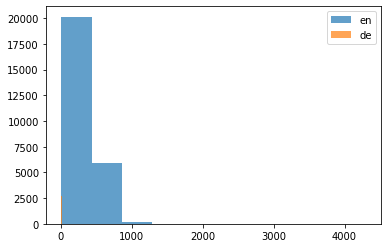

In [ ]:
len_en = list(map(len, encoder_input))
len_de = list(map(len, decoder_input))

plt.hist(len_en, label='en', alpha=0.7)
plt.hist(len_de, label='de', alpha=0.7)
plt.legend()
plt.show()

In [ ]:
print(f"인코더 데이터 길이 평균 : {np.mean(len_en)}")
print(f"디코더 데이터 길이 평균 : {np.mean(len_de)}")
print(f"인코더 데이터 길이 중간값 : {np.median(len_en)}")
print(f"디코더 데이터 길이 중간값 : {np.median(len_de)}")

인코더 데이터 길이 평균 : 261.1189430677002
디코더 데이터 길이 평균 : 6.9282523196762
인코더 데이터 길이 중간값 : 180.0
디코더 데이터 길이 중간값 : 7.0


In [ ]:
# padding="post" : 앞부터 문장, 뒤에 0값을 채우기 위해
encoder_input = pad_sequences(encoder_input, padding="post", maxlen=500)
decoder_input = pad_sequences(decoder_input, padding="post")
decoder_output = pad_sequences(decoder_output, padding="post")

print(encoder_input[:3])
print(decoder_input[:3])
print(decoder_output[:3])
print(encoder_input.shape)
print(decoder_input.shape)

[[   47 32930   810 ...     0     0     0]
 [  779 30192 21014 ...     0     0     0]
 [  244   542 11308 ...  4992     3   980]]
[[    1  2867 14549   668 14550  2868     0     0     0     0     0     0
      0     0]
 [    1 14551  1984  9014   339 14552     0     0     0     0     0     0
      0     0]
 [    1  6582  6583  9015   134     0     0     0     0     0     0     0
      0     0]]
[[ 2867 14549   668 14550  2868     2     0     0     0     0     0     0
      0     0]
 [14551  1984  9014   339 14552     2     0     0     0     0     0     0
      0     0]
 [ 6582  6583  9015   134     2     0     0     0     0     0     0     0
      0     0]]
(26189, 500)
(26189, 14)


In [ ]:
# 나중에 prediction 할 때 사용하기 위함(인덱스로 단어 찾기)
de_to_index = tokenizer_de.word_index
index_to_de = tokenizer_de.index_word

In [ ]:
test_size = 5000
encoder_input_train = encoder_input[:-test_size]
decoder_input_train = decoder_input[:-test_size]
decoder_output_train = decoder_output[:-test_size]

encoder_input_test = encoder_input[-test_size:]
decoder_input_test = decoder_input[-test_size:]
decoder_output_test = decoder_output[-test_size:]

# Training

In [ ]:
# hyperparameter
word_embedding = 100
LSTM_unit = 50

In [ ]:
encoder_inputs = Input(shape=(encoder_input.shape[1],))
encoder_embed = Embedding(len(tokenizer_en.word_index)+1, word_embedding)(encoder_inputs)
encoder_mask = Masking(mask_value=0)(encoder_embed)
encoder_outputs, h_state, c_state = LSTM(LSTM_unit, return_state=True, return_sequences=True)(encoder_mask)

In [ ]:
decoder_inputs = Input(shape=(decoder_input.shape[1],))
decoder_embed = Embedding(len(tokenizer_de.word_index)+1, word_embedding)(decoder_inputs)
decoder_mask = Masking(mask_value=0)(decoder_embed)
decoder_lstm = LSTM(LSTM_unit, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_mask, initial_state=[h_state, c_state])

In [ ]:
from attention import AttentionLayer

attn_layer = AttentionLayer()
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])
decoder_concat_input = Concatenate()([decoder_outputs, attn_out])

decoder_dense = Dense(len(tokenizer_en.word_index)+1, activation='softmax')
decoder_softmax_outputs = decoder_dense(decoder_concat_input)

In [ ]:
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 14)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 500, 100)     72525900    input_6[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 14, 100)      3970000     input_7[0][0]                    
_______________________________________________________________________________________

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model_check = ModelCheckpoint('./seq2seq_news_title.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_output_train,
          validation_data=([encoder_input_test, decoder_input_test], decoder_output_test),
          batch_size=32, epochs=100,
          callbacks=[early_stop, model_check])

Epoch 1/100
663/663 [==============================] - ETA: 0s - loss: 5.0202 - acc: 0.5619
Epoch 00001: val_acc improved from -inf to 0.57669, saving model to ./seq2seq_news_title.h5
663/663 [==============================] - 536s 808ms/step - loss: 5.0202 - acc: 0.5619 - val_loss: 4.5188 - val_acc: 0.5767
Epoch 2/100
663/663 [==============================] - ETA: 0s - loss: 4.3917 - acc: 0.5784
Epoch 00002: val_acc improved from 0.57669 to 0.57813, saving model to ./seq2seq_news_title.h5
663/663 [==============================] - 534s 806ms/step - loss: 4.3917 - acc: 0.5784 - val_loss: 4.4299 - val_acc: 0.5781
Epoch 3/100
663/663 [==============================] - ETA: 0s - loss: 4.3165 - acc: 0.5804
Epoch 00003: val_acc improved from 0.57813 to 0.58030, saving model to ./seq2seq_news_title.h5
663/663 [==============================] - 528s 796ms/step - loss: 4.3165 - acc: 0.5804 - val_loss: 4.4106 - val_acc: 0.5803
Epoch 4/100
663/663 [==============================] - ETA: 0s - lo

# Prediction

In [ ]:
encoder_model = Model(encoder_inputs, [encoder_outputs, h_state, c_state])

In [ ]:
encoder_h_state = Input(shape=(LSTM_unit,))
encoder_c_state = Input(shape=(LSTM_unit,))

pd_decoder_outputs, pd_h_state, pd_c_state = decoder_lstm(decoder_mask, initial_state=[encoder_h_state, encoder_c_state])

# 어텐션
pd_encoder_outputs = Input(shape=(encoder_input.shape[1], LSTM_unit))
pd_attn_out, pd_attn_states = attn_layer([pd_encoder_outputs, pd_decoder_outputs])
pd_decoder_concat = Concatenate()([pd_decoder_outputs, pd_attn_out])

pd_decoder_softmax_outputs = decoder_dense(pd_decoder_concat)

decoder_model = Model([decoder_inputs, pd_encoder_outputs, encoder_h_state, encoder_c_state], [pd_decoder_softmax_outputs, pd_h_state, pd_c_state])

In [ ]:
input_stc = input()
token_stc = input_stc.replace("\n"," ").replace(" +", " ").replace("[^\w]","").split()
encode_stc = tokenizer_en.texts_to_sequences([token_stc])
pad_stc = pad_sequences(encode_stc, maxlen=encoder_input.shape[1], padding="post")

en_out, en_hidden, en_cell = encoder_model.predict(pad_stc)

predicted_seq = np.zeros((1,1))
predicted_seq[0,0] = de_to_index["<start>"]

decoded_stc = []

while True:
    output_words, h, c = decoder_model.predict([predicted_seq, en_out, en_hidden, en_cell])

    predicted_word = index_to_de[np.argmax(output_words[0,0])]

    if predicted_word == "<end>":
        break
    
    decoded_stc.append(predicted_word)

    predicted_seq = np.zeros((1,1))
    predicted_seq[0,0] = np.argmax(output_words[0,0])

    en_hidden = h
    en_cell = c

print(' '.join(decoded_stc))

IT서비스 개발인력이 코로나 위협에 내몰리고 있다. 고객사가 마련한 좁은 공간에 모여 프로젝트를 수행할 수밖에 없는 구조적 현실 때문이다. 고객사 배려와 부분 원격지 근무 의무화 등 제도적 보완이 요구된다.  코로나19가 장기화되면서 고객사에 파견된 IT서비스 인력 사이에서 건강 우려가 확산된다.  고객사 시스템을 구축하는 개발자는 프로젝트 기간 동안 고객사가 지정한 장소에서 수개월~수년간 근무한다. 비좁고 밀폐된 임시 장소에서 다수가 근무하기 때문에 코로나 같은 감염병에 취약하다.  A은행 IT시스템을 구축 중인 한 IT서비스 기업 개발자는 “A은행 건물 1층을 활용해 프로젝트를 진행하는데 막바지가 될수록 투입 인원이 늘어난다”면서 “교실 4개 크기 공간에 200명 가까운 인력이 콩나물처럼 모여 근무 중”이라고 말했다.  그는 “임시 공간이다 보니 휴게실이나 회의실 같은 구분이 없어 확진자 1명만 나와도 수백명이 격리에 들어가야 하는 상황”이라며 “조금만 움직여도 몸이 닿을 듯한 거리에서 작업을 하고 있어서 모두의 불안감이 커지고 있다”고 털어놨다.  재택이나 순환 근무를 허용하는 고객사도 있다. 30억~40억원 미만 중소 프로젝트 중에서는 원격개발 방식을 택한 사례도 있다. 그러나 많은 인력이 필요한 중대형 IT프로젝트는 대부분 A은행과 같은 상황에서 진행된다. 규모가 클수록 보안 등 이유로 재택 전환이나 원격지 개발이 어렵기 때문이다.  고객사가 내부 계열사라도 상황은 다르지 않다.  또 다른 IT서비스 기업 관계자는 “내부 계열사라고 해서 납기를 연장해주는 게 아니라서 어쩔 수 없이 출근을 해야 한다”면서 “고객사는 필요하면 필수인력 제외하고 재택을 하라고 하지만 어디까지나 권고일 뿐”이라고 말했다.  IT서비스 기업 인력은 본인이 코로나에 감염될까 걱정한다. 본인으로 인해 중요 프로젝트가 중단되는 것은 더 두려워한다.  파견 인력이 본사 직원에게 느끼는 상실감도 존재한다. 한 대형 IT서비스 기업 본사는 코로나 확산에 따라 재택근무에 돌입했다. 그러나